# Agentic Workflow using Langgraph

# QA bot on solar system

### RAG Creation

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['PINECONE_API_KEY'] = os.getenv('PINECONE_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import DirectoryLoader,PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pinecone import ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langchain_community.tools import TavilySearchResults

/Users/nikki/Documents/Agentic AI/Agentic_AI_Assignments/Assignment4/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [5]:
# Creating Embedding model
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001')

#### Loading Documents

In [6]:
# Document Loader
loader = DirectoryLoader('./data',glob='./*.pdf',loader_cls=PyPDFLoader)

In [7]:
docs = loader.load()

In [8]:
docs[0]

Document(metadata={'producer': 'pdfTeX-1.40.12', 'creator': 'LaTeX with hyperref package', 'creationdate': '2015-01-14T07:29:29+00:00', 'author': '', 'keywords': '', 'moddate': '2015-01-14T07:29:29+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-2.3-1.40.12 (TeX Live 2011) kpathsea version 6.0.1', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'data/The_formation_of_the_solar_system.pdf', 'total_pages': 36, 'page': 0, 'page_label': '1'}, page_content='The formation of the solar system\nS Pfalzner1, M B Davies2, M Gounelle3,4, A Johansen2, C M¨unker5,\nP Lacerda6, S Portegies Zwart7, L Testi8,9, M Trieloﬀ10 & D Veras11\n1 Max-Planck Institut f¨ur Radioastronomie, Auf dem H¨ugel 69, 53121 Bonn, Germany\n2 Lund Observatory, Department of Astronomy and Theoretical Physics, Box 43, 22100\nLund, Sweden\n3 IMPMC, Mus´eum National d’Histoire Naturelle, Sorbonne Universit´es, CNRS, UPMC &\nIRD, 57 rue Cuvier, 75005 Paris, France\n4 Institut Universitaire de France, 103

In [9]:
# Splitting into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=200,chunk_overlap=50)
splitted_docs = splitter.split_documents(documents=loader.load())

In [10]:
splitted_docs

[Document(metadata={'producer': 'pdfTeX-1.40.12', 'creator': 'LaTeX with hyperref package', 'creationdate': '2015-01-14T07:29:29+00:00', 'author': '', 'keywords': '', 'moddate': '2015-01-14T07:29:29+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-2.3-1.40.12 (TeX Live 2011) kpathsea version 6.0.1', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'data/The_formation_of_the_solar_system.pdf', 'total_pages': 36, 'page': 0, 'page_label': '1'}, page_content='The formation of the solar system\nS Pfalzner1, M B Davies2, M Gounelle3,4, A Johansen2, C M¨unker5,\nP Lacerda6, S Portegies Zwart7, L Testi8,9, M Trieloﬀ10 & D Veras11'),
 Document(metadata={'producer': 'pdfTeX-1.40.12', 'creator': 'LaTeX with hyperref package', 'creationdate': '2015-01-14T07:29:29+00:00', 'author': '', 'keywords': '', 'moddate': '2015-01-14T07:29:29+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-2.3-1.40.12 (TeX Live 2011) kpathsea version 6.0.1', 'subject': '', 'title': '', 't

In [11]:
doc_string = [doc.page_content for doc in splitted_docs]
doc_string


['The formation of the solar system\nS Pfalzner1, M B Davies2, M Gounelle3,4, A Johansen2, C M¨unker5,\nP Lacerda6, S Portegies Zwart7, L Testi8,9, M Trieloﬀ10 & D Veras11',
 '1 Max-Planck Institut f¨ur Radioastronomie, Auf dem H¨ugel 69, 53121 Bonn, Germany\n2 Lund Observatory, Department of Astronomy and Theoretical Physics, Box 43, 22100\nLund, Sweden',
 'Lund, Sweden\n3 IMPMC, Mus´eum National d’Histoire Naturelle, Sorbonne Universit´es, CNRS, UPMC &\nIRD, 57 rue Cuvier, 75005 Paris, France',
 'IRD, 57 rue Cuvier, 75005 Paris, France\n4 Institut Universitaire de France, 103 boulevard Saint-Michel, 75005 Paris, France',
 '5 Institut f¨ur Geologie und Mineralogie, Universit¨at zu K¨oln, Z¨ulpicherstr. 49b 50674 K¨oln,\nGermany\n6 Max-Planck-Institut f¨ur Sonnensystemforschung, Justus-von-Liebig-Weg 3, 37077',
 'G¨ottingen, Germany\n7 Leiden University, Sterrewacht Leiden, PO-Box 9513, 2300 RA Leiden, the Netherlands\n8 ESO, Karl Schwarzschild str. 2, D-85748 Garching, Germany',
 '9 I

In [12]:
len(doc_string)

618

#### VectorDB creation

In [13]:
# Let's create a pinecone vector db

pinecone_api_key = os.getenv('PINECONE_API_KEY') 

In [14]:
from pinecone import Pinecone

pc = Pinecone(api_key=pinecone_api_key)

In [15]:
index_name = 'solarsytemvdb'

In [16]:
if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        spec=ServerlessSpec(cloud='aws',region='us-east-1'),
        dimension=768,
        metric='cosine'
    )

In [17]:
# Load index
index = pc.Index(index_name)

In [18]:
vectorStore = PineconeVectorStore(index=index,embedding=embeddings)

In [19]:
vectorStore.add_documents(documents=splitted_docs)

['010059bb-06cb-460a-9eb1-752d464976d9',
 '32473797-e6ae-4c80-82d6-5b5d0d25e03d',
 '58411a07-1048-4156-8d2a-bddeb2d96bb8',
 'd86b1e4b-453c-43b5-a1b3-a99f269d5b7d',
 '37e774e2-0fed-4abf-9c59-a715af7206ad',
 'd7c1013f-2500-434a-a3f1-fcc3c9d30c9d',
 'adca3ff5-b5e7-4cbd-8b40-6b7eee4d4e73',
 'ef01411c-deb3-4274-af38-28eb03dbe857',
 '4c63948f-ce73-4942-bd0b-50aefa06a810',
 '9437b62f-e412-4ec8-86a4-ec3a71f25779',
 '31ccdf24-0a93-4442-b47a-6e636f45f654',
 '0318c3af-f392-423c-a064-3f7259f18d08',
 '6e35877b-6226-4f5d-acd3-11ea639b50a1',
 '490c504d-10d8-40d1-b0e3-b7d95f0618c8',
 'a9454454-908a-4638-b522-4b90cd1eb508',
 '9841ab59-d3af-49df-a4fb-7083febd4ee4',
 'de9337b8-132d-4f75-9f7a-fbce6b40c505',
 '00b7ef16-d471-4d17-85dc-0385364b5605',
 'f9e7775f-7457-4bf3-8285-5037fdb5b290',
 '2509d964-888f-4692-9750-6a2c2637ce5f',
 '5e176215-1cb5-4c38-a24a-73bb400a2ee3',
 'c9d9280d-4e50-4f3d-be58-c3de020de675',
 'f039b6ac-149c-414b-a841-50e69b165f58',
 'bd37cabc-72d9-4d7f-930a-ddaa24ed5852',
 '27157151-5bf2-

In [20]:
vectorStore.similarity_search('sun',k=5)

[Document(id='edf064e6-e79f-4d9c-ab19-bbec3f60c407', metadata={'author': '', 'creationdate': '2015-01-14T07:29:29+00:00', 'creator': 'LaTeX with hyperref package', 'keywords': '', 'moddate': '2015-01-14T07:29:29+00:00', 'page': 17.0, 'page_label': '18', 'producer': 'pdfTeX-1.40.12', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-2.3-1.40.12 (TeX Live 2011) kpathsea version 6.0.1', 'source': 'data/The_formation_of_the_solar_system.pdf', 'subject': '', 'title': '', 'total_pages': 36.0, 'trapped': '/False'}, page_content='the Sun and M 67 are similar ( ¨Onehag et al., 2014).'),
 Document(id='52c86927-ff0f-466b-a8dd-32211ed753dc', metadata={'author': '', 'creationdate': '2015-01-14T07:29:29+00:00', 'creator': 'LaTeX with hyperref package', 'keywords': '', 'moddate': '2015-01-14T07:29:29+00:00', 'page': 17.0, 'page_label': '18', 'producer': 'pdfTeX-1.40.12', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-2.3-1.40.12 (TeX Live 2011) kpathsea version 6.0.1', 'source': 'data/The_

#### Creating Retriever pipeline

In [21]:
retriever = vectorStore.as_retriever(
    search_type='similarity_score_threshold',
    search_kwargs={"score_threshold":0.7}
)

In [22]:
retriever.invoke('What is Sun?')

[Document(id='55fc67e7-0507-4840-a56f-55b477eac235', metadata={'author': '', 'creationdate': '2015-01-14T07:29:29+00:00', 'creator': 'LaTeX with hyperref package', 'keywords': '', 'moddate': '2015-01-14T07:29:29+00:00', 'page': 22.0, 'page_label': '23', 'producer': 'pdfTeX-1.40.12', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-2.3-1.40.12 (TeX Live 2011) kpathsea version 6.0.1', 'source': 'data/The_formation_of_the_solar_system.pdf', 'subject': '', 'title': '', 'total_pages': 36.0, 'trapped': '/False'}, page_content='parts depending on the state of the Sun: (i) the main sequence and (ii) post-main-sequence\nphases of Solar evolution.'),
 Document(id='b4acdbe3-ef84-4f96-8f0b-4039a0cf831e', metadata={'author': '', 'creationdate': '2015-01-14T07:29:29+00:00', 'creator': 'LaTeX with hyperref package', 'keywords': '', 'moddate': '2015-01-14T07:29:29+00:00', 'page': 22.0, 'page_label': '23', 'producer': 'pdfTeX-1.40.12', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-2.3-1.40

## Web crawler Creation

In [23]:
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [24]:
web_crawler = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

/var/folders/8g/sz3w79_54bgdwgjzjt0tn92h0000gn/T/ipykernel_87517/3749762850.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_crawler = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


In [25]:
web_crawler.invoke("what happened to RCB management?")

[{'title': 'RCB to be sold: New Management Coming? - Tupaki English',
  'url': 'https://english.tupaki.com/latest-news/rcb-franchise-sold-rumors-1431256',
  'content': 'Despite not having won the IPL trophy in the last 17 years, Royal Challengers, Bengaluru happened to be the most followed team in the tournament, and they finally created history by winning the trophy for the first time this year.\n\nHowever, it appears that the trophy winning team is still undergoing serious changes at the management level as the latest update updates are suggesting that the existing owners are looking to sell the franchise. [...] After winning their first-ever IPL title, Royal Challengers Bengaluru (RCB) have made headlines again. Reports suggest that the team’s owners are now planning to sell the franchise for a whopping ₹16,834 crore. RCB is owned by United Spirits, a subsidiary of the global liquor giant Diageo. [...] ![](https://sb.scorecardresearch.com/p?c1=2&c2=39547594&cv=3.9.1&cj=1)\n![Tupaki 

## Workflow creation

In [26]:
from pydantic import BaseModel, Field
from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough
from IPython.display import Image, display


In [27]:
# Agent state creation
import operator
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [28]:
# Pydantic class craetion
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="Selected Topic")
    Reasoning: str = Field(description="Reasoning behind topic selected")


In [29]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [30]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selected", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [31]:
# Supervisor node
def supervisor(state:AgentState):
    print("--> SUPERVISOR -->")
    question = state["messages"][-1]
    print("Question:", question)

    template="""
    Your task is to classify the given user query into one of the following categories: [Solar System, Not Related, Real Time]. 
    Only respond with the category name and nothing else.
    Rule for classyfying:
    If the question talks about solar system or planets or similar info then classify it as 'Solar System',
    If question talks about sonme recent or latest information, then classify it to 'Real Time Info'.
    Otherwise, classify it to 'Not Related'.

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    res = chain.invoke({"question":question})

    print("Response: ", res)

    return {"messages": [res.Topic]}


In [32]:
# Router node
def router(state:AgentState):
    print("--> ROUTER -->")
    last_message = state["messages"][-1].lower()
    print("Last Message:",last_message)

    if "solar system" in last_message:
        return "RAG call"
    elif "real time" in last_message:
        return "Web Crawler call"
    else:
        return "LLM call"

In [33]:
def format_docs(docs):
    return "/n/n".join([doc.page_content for doc in docs])

In [ ]:
# Rag Node
def ragOnSS(state:AgentState):
    print("--> RAG -->")

    question= state["messages"][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return {"messages": [result]}

In [35]:
# LLM node
def llm(state:AgentState):
    print("--> LLM call -->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}
    

In [ ]:
# Web crawler node
def webCrawler(state: AgentState):
    print("--> Web Crawler call -->")
    question = state["messages"][0]

    res = web_crawler.invoke({"query":question})

    return {"messages":[res[0].content]}
    

In [ ]:
# validation node

def validator(state:AgentState):
    print("--> Validator -->")

    ans = state["messages"][-1].lower()

    if "i don't know" in ans or len(ans.strip()) < 10:
        return {"messages":["retry"]}
    
    return {"messages":[ans]}

In [38]:
# retry roter

def retryRouter(state: AgentState):
    print("--> IN RETRY ROUTER -->")

    msg = state["messages"][-1]
    if msg == "retry":
        return "Supervisor"
    return "Final result"

In [39]:
# final node
def finalNode(state:AgentState):
    print("--> IN Final Node -->")
    return {"messages": [f"✅ Final Answer: {state['messages'][-1]}"]}

In [40]:
from langgraph.graph import StateGraph,END

In [41]:
workflow = StateGraph(AgentState)

In [42]:
workflow.add_node("Supervisor",supervisor)
workflow.add_node("RAG",ragOnSS)
workflow.add_node("LLM",llm)
workflow.add_node("Web Crawler",webCrawler)
workflow.add_node("Validator",validator)
workflow.add_node("Final",finalNode)

In [43]:
workflow.set_entry_point("Supervisor")

In [44]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG call": "RAG",
        "LLM call": "LLM",
        "Web Crawler call": "Web Crawler"
    }
)

In [45]:
workflow.add_edge("RAG","Validator")
workflow.add_edge("LLM","Validator")
workflow.add_edge("Web Crawler","Validator")

In [46]:
workflow.add_conditional_edges(
    "Validator",
    retryRouter,
    {
        "Supervisor": "Supervisor",
        "Final result": "Final"
    }
)

In [47]:
workflow.add_edge("Final",END)

In [48]:
app = workflow.compile()

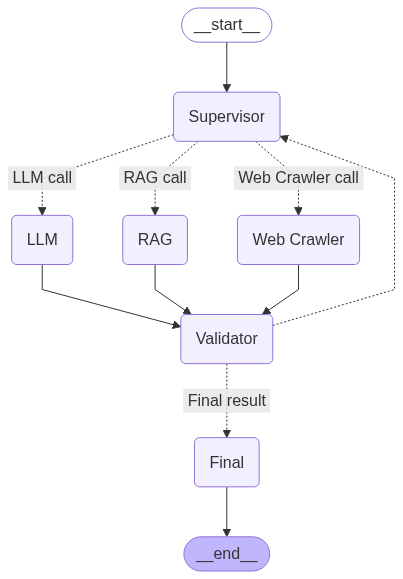

In [49]:
display(Image(app.get_graph().draw_mermaid_png()))

In [50]:
state = {"messages":["Hi!"]}

In [51]:
result = app.invoke(state)
result

--> SUPERVISOR -->
Question: Hi!
Response:  Topic='Not Related' Reasoning='The query "Hi!" does not contain information related to the solar system, real-time events, or any other specified category.'
--> ROUTER -->
Last Message: not related
--> LLM call -->
--> Validator -->
--> IN RETRY ROUTER -->
--> IN Final Node -->


{'messages': ['Hi!',
  'Not Related',
  'Hi!  How can I help you today?',
  'hi!  how can i help you today?',
  '✅ Final Answer: hi!  how can i help you today?']}

In [52]:
result["messages"][-1]

'✅ Final Answer: hi!  how can i help you today?'

In [56]:
state={"messages":["Solar System"]}

In [57]:
result = app.invoke(state)
result

--> SUPERVISOR -->
Question: Solar System
Response:  Topic='Solar System' Reasoning="The query explicitly mentions 'Solar System'."
--> ROUTER -->
Last Message: solar system
--> RAG -->
--> Validator -->
--> IN RETRY ROUTER -->
--> IN Final Node -->


{'messages': ['Solar System',
  'Solar System',
  "The provided text focuses on the solar system's formation and its future, noting that it was once considered a prototype for planetary system formation.  More information is needed to fully answer your question about the solar system.",
  "the provided text focuses on the solar system's formation and its future, noting that it was once considered a prototype for planetary system formation.  more information is needed to fully answer your question about the solar system.",
  "✅ Final Answer: the provided text focuses on the solar system's formation and its future, noting that it was once considered a prototype for planetary system formation.  more information is needed to fully answer your question about the solar system."]}

In [58]:
state={"messages":["is sun big?"]}

In [59]:
result = app.invoke(state)
result

--> SUPERVISOR -->
Question: is sun big?
Response:  Topic='Solar System' Reasoning='The query asks about the size of the sun, which is a topic related to the solar system.'
--> ROUTER -->
Last Message: solar system
--> RAG -->
--> Validator -->
--> IN RETRY ROUTER -->
--> IN Final Node -->


{'messages': ['is sun big?',
  'Solar System',
  'Yes, the Sun is large.  When it becomes a red giant, its radius will be nearly 1 AU.  This is significantly larger than its current size.',
  'yes, the sun is large.  when it becomes a red giant, its radius will be nearly 1 au.  this is significantly larger than its current size.',
  '✅ Final Answer: yes, the sun is large.  when it becomes a red giant, its radius will be nearly 1 au.  this is significantly larger than its current size.']}

In [62]:
state={"messages":["What happened to RCB management in IPL?"]}

In [63]:
result = app.invoke(state)
result

--> SUPERVISOR -->
Question: What happened to RCB management in IPL?
Response:  Topic='Not Related' Reasoning='The query is about the management changes in the IPL cricket team RCB, which is unrelated to the solar system or real-time information.'
--> ROUTER -->
Last Message: not related
--> LLM call -->
--> Validator -->
--> IN RETRY ROUTER -->
--> IN Final Node -->


{'messages': ['What happened to RCB management in IPL?',
  'Not Related',
  "There haven't been any major, publicly announced shake-ups in the top management of the Royal Challengers Bangalore (RCB) IPL franchise recently.  While there are always behind-the-scenes changes in personnel and strategies, no significant shifts in leadership have been widely reported in mainstream sports news.  The ownership group and key figures remain largely the same.",
  "there haven't been any major, publicly announced shake-ups in the top management of the royal challengers bangalore (rcb) ipl franchise recently.  while there are always behind-the-scenes changes in personnel and strategies, no significant shifts in leadership have been widely reported in mainstream sports news.  the ownership group and key figures remain largely the same.",
  "✅ Final Answer: there haven't been any major, publicly announced shake-ups in the top management of the royal challengers bangalore (rcb) ipl franchise recently.

In [64]:
state={"messages":["can u tell anything about earth"]}

In [65]:
result = app.invoke(state)
result

--> SUPERVISOR -->
Question: can u tell anything about earth
Response:  Topic='Solar System' Reasoning='The query asks for information about Earth, which is a planet in our solar system.'
--> ROUTER -->
Last Message: solar system
--> RAG -->
--> Validator -->
--> IN RETRY ROUTER -->
--> IN Final Node -->


{'messages': ['can u tell anything about earth',
  'Solar System',
  "Based on the provided text, Earth's future is uncertain.  The text suggests a catastrophic event where Mercury and Venus are destroyed, implying a similar, though unspecified, fate for Earth.  More information is needed for a complete answer.",
  "based on the provided text, earth's future is uncertain.  the text suggests a catastrophic event where mercury and venus are destroyed, implying a similar, though unspecified, fate for earth.  more information is needed for a complete answer.",
  "✅ Final Answer: based on the provided text, earth's future is uncertain.  the text suggests a catastrophic event where mercury and venus are destroyed, implying a similar, though unspecified, fate for earth.  more information is needed for a complete answer."]}

In [66]:
state={"messages":["what is Solar Sysytem?"]}

In [67]:
result = app.invoke(state)
result

--> SUPERVISOR -->
Question: what is Solar Sysytem?
Response:  Topic='Solar System' Reasoning='The question directly asks about the Solar System.'
--> ROUTER -->
Last Message: solar system
--> RAG -->
--> Validator -->
--> IN RETRY ROUTER -->
--> IN Final Node -->


{'messages': ['what is Solar Sysytem?',
  'Solar System',
  'The solar system is a planetary system.  For decades, it was considered the model for how planetary systems form.  Its formation and future are subjects of ongoing study.',
  'the solar system is a planetary system.  for decades, it was considered the model for how planetary systems form.  its formation and future are subjects of ongoing study.',
  '✅ Final Answer: the solar system is a planetary system.  for decades, it was considered the model for how planetary systems form.  its formation and future are subjects of ongoing study.']}